## Extract the data from the source

In [34]:
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from docx import Document
import pandas as pd
import warnings
import os
warnings.filterwarnings("ignore")

`Scrape all tables inside the Word file`

In [35]:
doc = Document("../data/raw/Data Analyst Take-Home Challenge.docx")

tables_data = []

for table in doc.tables:
    
    data = []
    for row in table.rows:
        data.append([cell.text.strip() for cell in row.cells])
    
    df = pd.DataFrame(data)
    tables_data.append(df)

## Transform the data

In [36]:
finder_df = tables_data[0]

# promote first row to header and drop it from data
finder_df = finder_df[1:].reset_index(drop=True)

finder_df.columns = [
    "Event Type", "Category",
    "Much less than expected", "Less than expected",
    "Matched expectation", "Exceeded expectations",
    "Greatly exceeded expectations"
]

# encode likert scale
likert_map = {
    'Much less than expected': 1,
    'Less than expected': 2,
    'Matched expectation': 3,
    'Exceeded expectations': 4,
    'Greatly exceeded expectations': 5
}

# melt the data for scalability
finder_long = finder_df.melt(
    id_vars=["Event Type", "Category"],
    var_name="Rating",
    value_name="Count"
)

finder_long["Score"] = finder_long["Rating"].map(likert_map)

# ensure numeric column types
finder_long["Score"] = pd.to_numeric(finder_long["Score"], errors="coerce")
finder_long["Count"] = pd.to_numeric(finder_long["Count"], errors="coerce")

finder_long.head()

,Event Type,Category,Rating,Count,Score
0,Award night,Parking,Much less than expected,15,1
1,Award night,Venue location,Much less than expected,5,1
2,Award night,Seating,Much less than expected,25,1
3,Award night,Host,Much less than expected,19,1
4,Award night,Entertainment,Much less than expected,30,1


`Get the weighted scores for each category of event`

In [37]:
def weighted_mean(g):
    weighted_sum = (g["Score"] * g["Count"]).sum()
    total_count = g["Count"].sum()
    return weighted_sum / total_count

weighted_scores = (

    finder_long
        .groupby(["Event Type", "Category"])
        .apply(weighted_mean)
        .reset_index(name="Weighted Mean")
        .sort_values("Weighted Mean", ascending=False)
        
).sort_values(by=["Event Type","Weighted Mean"], ascending=False).reset_index(drop=True)

weighted_scores

,Event Type,Category,Weighted Mean
0,Other,Event communication,4.116
1,Other,PR package for winner,3.344
2,Other,Entry cost,2.660
3,Award night,Food,4.436
4,Award night,Host,4.228
5,Award night,Venue location,4.080
6,Award night,Wait staff,3.756
7,Award night,Parking,3.412
8,Award night,Entertainment,3.336
9,Award night,Seating,3.140


`Perform Chi-Square Test of Independence across categorical scores`

In [38]:
finder_pivot = finder_long.pivot_table(
    index="Category",
    columns="Score",
    values="Count",
    fill_value=0
)

chi2, p, dof, expected = chi2_contingency(finder_pivot)

print(f"Chi-square={chi2:.2f}, p-value={p:.5f}")

if p < 0.05:
    print("Scores differ significantly across categories — not independent.")
else:
    print("No significant difference — likely random variation.")

Chi-square=948.06, p-value=0.00000
Scores differ significantly across categories — not independent.


`Exploratory Visualizations`

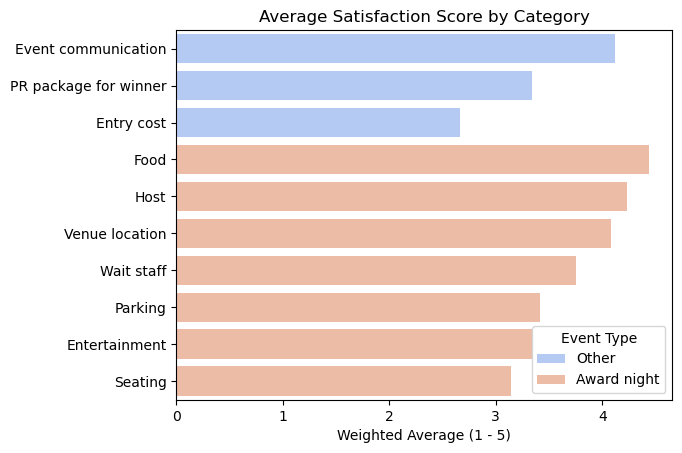

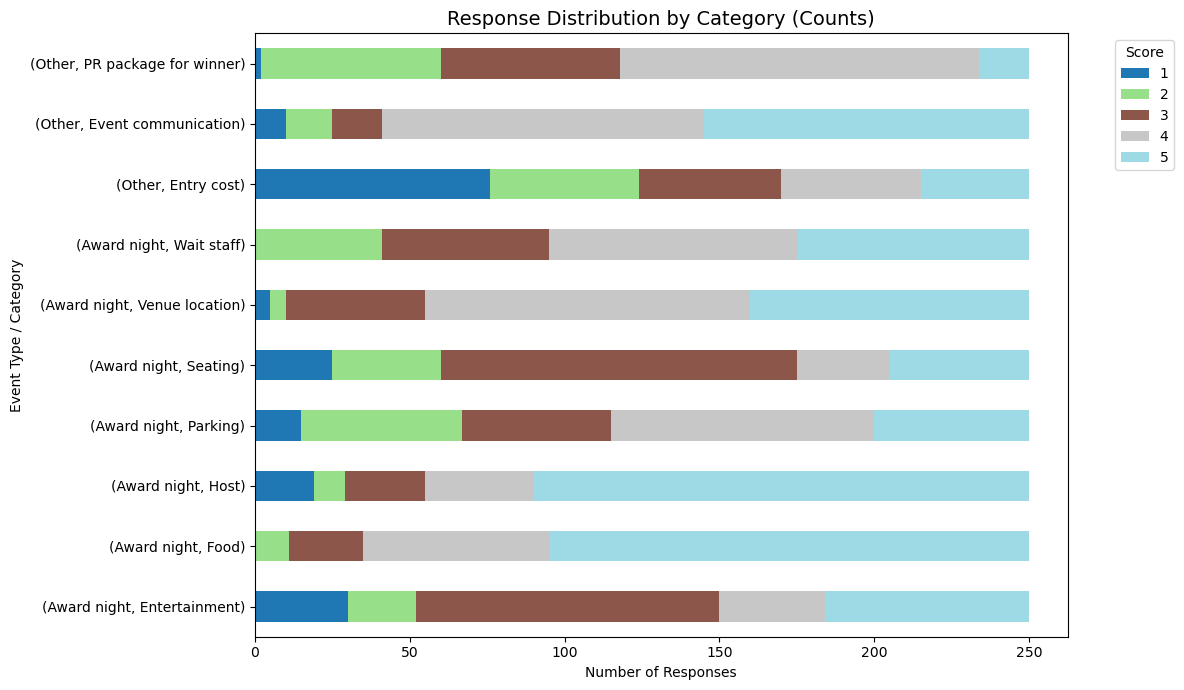

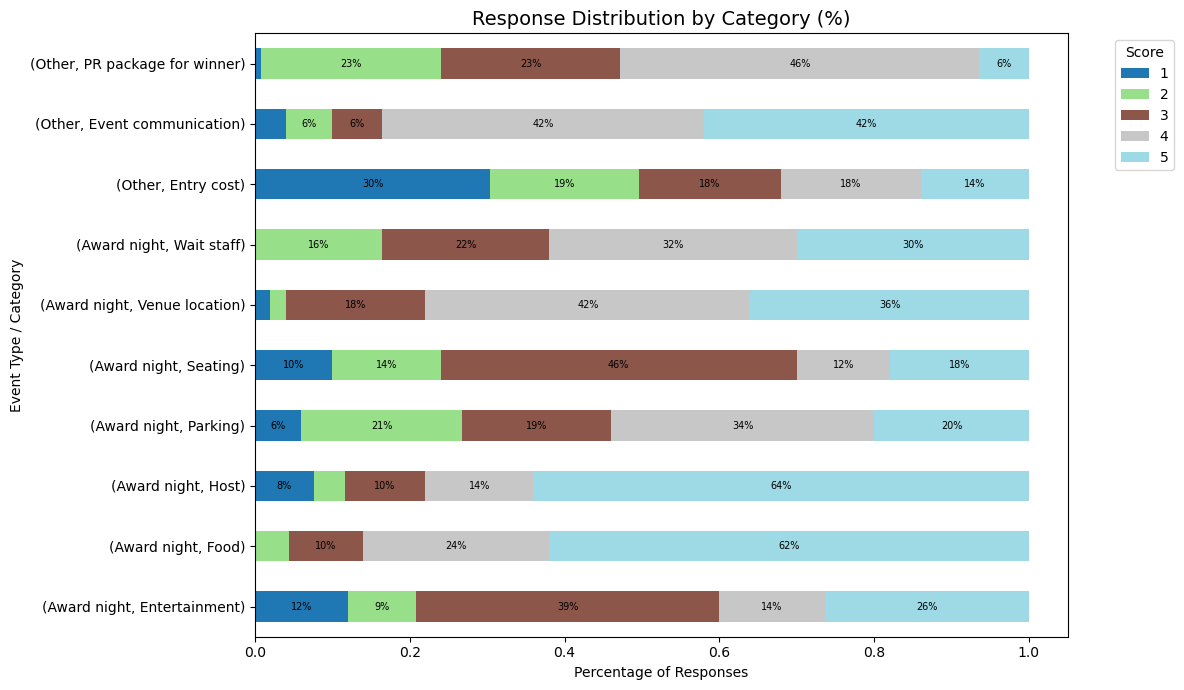

In [39]:
# Weighted average barplot
sns.barplot(
    data=weighted_scores,
    x="Weighted Mean",
    y="Category",
    hue="Event Type",
    palette="coolwarm"
)
plt.title("Average Satisfaction Score by Category")
plt.xlabel("Weighted Average (1 - 5)")
plt.ylabel("")
plt.show()


# Response Distribution
df_pivot = finder_long.pivot_table(
    index=["Event Type", "Category"],
    columns="Score",
    values="Count",
    aggfunc="sum",
    fill_value=0
)

# Response distribution by counts
df_sorted = df_pivot.copy()
df_sorted["Total"] = df_sorted.sum(axis=1)
df_sorted = df_sorted.sort_values("Total", ascending=True).drop(columns="Total")

ax = df_sorted.plot(
    kind="barh", stacked=True, figsize=(12, 7), colormap="tab20"
)
plt.title("Response Distribution by Category (Counts)", fontsize=14)
plt.xlabel("Number of Responses")
plt.ylabel("Event Type / Category")
plt.legend(title="Score", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Response distribution by Category
df_norm = df_pivot.div(df_pivot.sum(axis=1), axis=0)

ax = df_norm.plot(
    kind="barh", stacked=True, figsize=(12, 7), colormap="tab20"
)
plt.title("Response Distribution by Category (%)", fontsize=14)
plt.xlabel("Percentage of Responses")
plt.ylabel("Event Type / Category")
plt.legend(title="Score", bbox_to_anchor=(1.05, 1), loc="upper left")

# Annotate bars with percentage labels
for container in ax.containers:
    labels = []
    for v in container.datavalues:
        pct = v * 100
        labels.append(f"{pct:.0f}%" if pct >= 5 else "")  # label if ≥5%
    ax.bar_label(container, labels=labels, label_type="center", fontsize=7, color="black")

plt.tight_layout()
plt.show()



## Load the data into the BigQuery warehouse

In [40]:
from google.cloud import bigquery

In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../credentials/finders-au-service-acct.json"

client = bigquery.Client()

dataset_id = "finders-au.finder_award"
table_id = f"{dataset_id}.take_home_assignment"

schema = [
    bigquery.SchemaField("id", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("event_type", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("category", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("rating", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("count", "INTEGER", mode="NULLABLE"),
    bigquery.SchemaField("score", "INTEGER", mode="NULLABLE"),
]

table = bigquery.Table(table_id, schema=schema)
table.expires = None
table = client.create_table(table)

print(f"Created table {table.project}.{table.dataset_id}.{table.table_id}")

In [ ]:
finder_long.rename(columns={
    "Event Type": "event_type",
    "Category": "category",
    "Rating": "rating",
    "Count": "count",
    "Score": "score"
}, inplace=True)

finder_long.head()

,event_type,category,rating,count,score
0,Award night,Parking,Much less than expected,15,1
1,Award night,Venue location,Much less than expected,5,1
2,Award night,Seating,Much less than expected,25,1
3,Award night,Host,Much less than expected,19,1
4,Award night,Entertainment,Much less than expected,30,1


In [ ]:
finder_long.reset_index(inplace=True)
finder_long.rename(columns={"index": "id"}, inplace=True)

job = client.load_table_from_dataframe(finder_long, table_id)

job.result()

print(f"Loaded {job.output_rows} rows into {table_id}.")

Loaded 50 rows into finders-au.finder_award.take_home_assignment.
